# Dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

from keras import optimizers
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, Bidirectional, GlobalMaxPool1D

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

%matplotlib inline
sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.4f' % x)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
train = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv")
test = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv")
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (1804874, 45)
Test shape :  (97320, 2)


# Preprocess

In [3]:
train['target'] = np.where(train['target'] >= 0.5, 1, 0)
train['comment_text'] = train['comment_text'].astype(str)
X_test = test['comment_text'].astype(str)

In [4]:
# Lower comments
train['comment_text'] = train['comment_text'].apply(lambda x: x.lower())
X_test = X_test.apply(lambda x: x.lower())

In [5]:
# Mapping Punctuation
def map_punctuation(data):
    punct_mapping = {"_":" ", "`":" ",   
                     "‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", 
                     "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 
                     'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi'}
    def clean_special_chars(text, mapping):
        for p in mapping:
            text = text.replace(p, mapping[p])  
        return text

    return data.apply(lambda x: clean_special_chars(x, punct_mapping))

train['comment_text'] = map_punctuation(train['comment_text'])
X_test = map_punctuation(X_test)

In [6]:
# Removing Punctuation
def remove_punctuation(data):
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    return data.apply(lambda x: clean_special_chars(x, punct))

train['comment_text'] = remove_punctuation(train['comment_text'])
X_test = remove_punctuation(X_test)

In [7]:
# Clean contractions
def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    return text

train['comment_text'] = train['comment_text'].apply(lambda x: clean_contractions(x))
X_test = X_test.apply(lambda x: clean_contractions(x))

In [8]:
# Mapping contraction
def map_contraction(data):
    contraction_mapping = {"trump's": 'trump is', "'cause": 'because', ',cause': 'because', ';cause': 'because', "ain't": 'am not', 'ain,t': 'am not', 'ain;t': 'am not', 
                           'ain´t': 'am not', 'ain’t': 'am not', "aren't": 'are not', 'aren,t': 'are not', 'aren;t': 'are not', 'aren´t': 'are not', 'aren’t': 'are not', 
                           "can't": 'cannot', "can't've": 'cannot have', 'can,t': 'cannot', 'can,t,ve': 'cannot have', 'can;t': 'cannot', 'can;t;ve': 'cannot have', 
                           'can´t': 'cannot', 'can´t´ve': 'cannot have', 'can’t': 'cannot', 'can’t’ve': 'cannot have', "could've": 'could have', 'could,ve': 'could have', 
                           'could;ve': 'could have', "couldn't": 'could not', "couldn't've": 'could not have', 'couldn,t': 'could not', 'couldn,t,ve': 'could not have', 
                           'couldn;t': 'could not', 'couldn;t;ve': 'could not have', 'couldn´t': 'could not', 'couldn´t´ve': 'could not have', 'couldn’t': 'could not', 
                           'couldn’t’ve': 'could not have', 'could´ve': 'could have', 'could’ve': 'could have', "didn't": 'did not', 'didn,t': 'did not', 'didn;t': 'did not', 
                           'didn´t': 'did not', 'didn’t': 'did not', "doesn't": 'does not', 'doesn,t': 'does not', 'doesn;t': 'does not', 'doesn´t': 'does not', 'doesn’t': 'does not', 
                           "don't": 'do not', 'don,t': 'do not', 'don;t': 'do not', 'don´t': 'do not', 'don’t': 'do not', "hadn't": 'had not', "hadn't've": 'had not have', 
                           'hadn,t': 'had not', 'hadn,t,ve': 'had not have', 'hadn;t': 'had not', 'hadn;t;ve': 'had not have', 'hadn´t': 'had not', 'hadn´t´ve': 'had not have', 
                           'hadn’t': 'had not', 'hadn’t’ve': 'had not have', "hasn't": 'has not', 'hasn,t': 'has not', 'hasn;t': 'has not', 'hasn´t': 'has not', 'hasn’t': 'has not', 
                           "haven't": 'have not', 'haven,t': 'have not', 'haven;t': 'have not', 'haven´t': 'have not', 'haven’t': 'have not', "he'd": 'he would', "he'd've": 'he would have', 
                           "he'll": 'he will', "he's": 'he is', 'he,d': 'he would', 'he,d,ve': 'he would have', 'he,ll': 'he will', 'he,s': 'he is', 'he;d': 'he would', 
                           'he;d;ve': 'he would have', 'he;ll': 'he will', 'he;s': 'he is', 'he´d': 'he would', 'he´d´ve': 'he would have', 'he´ll': 'he will', 'he´s': 'he is', 
                           'he’d': 'he would', 'he’d’ve': 'he would have', 'he’ll': 'he will', 'he’s': 'he is', "how'd": 'how did', "how'll": 'how will', "how's": 'how is', 
                           'how,d': 'how did', 'how,ll': 'how will', 'how,s': 'how is', 'how;d': 'how did', 'how;ll': 'how will', 'how;s': 'how is', 'how´d': 'how did', 'how´ll': 
                           'how will', 'how´s': 'how is', 'how’d': 'how did', 'how’ll': 'how will', 'how’s': 'how is', "i'd": 'i would', "i'll": 'i will', "i'm": 'i am', "i've": 
                           'i have', 'i,d': 'i would', 'i,ll': 'i will', 'i,m': 'i am', 'i,ve': 'i have', 'i;d': 'i would', 'i;ll': 'i will', 'i;m': 'i am', 'i;ve': 'i have', 
                           "isn't": 'is not', 'isn,t': 'is not', 'isn;t': 'is not', 'isn´t': 'is not', 'isn’t': 'is not', "it'd": 'it would', "it'll": 'it will', "it's": 'it is', 
                           'it,d': 'it would', 'it,ll': 'it will', 'it,s': 'it is', 'it;d': 'it would', 'it;ll': 'it will', 'it;s': 'it is', 'it´d': 'it would', 'it´ll': 'it will', 
                           'it´s': 'it is', 'it’d': 'it would', 'it’ll': 'it will', 'it’s': 'it is', 'i´d': 'i would', 'i´ll': 'i will', 'i´m': 'i am', 'i´ve': 'i have', 'i’d': 'i would', 
                           'i’ll': 'i will', 'i’m': 'i am', 'i’ve': 'i have', "let's": 'let us', 'let,s': 'let us', 'let;s': 'let us', 'let´s': 'let us', 'let’s': 'let us', "ma'am": 'madam', 
                           'ma,am': 'madam', 'ma;am': 'madam', "mayn't": 'may not', 'mayn,t': 'may not', 'mayn;t': 'may not', 'mayn´t': 'may not', 'mayn’t': 'may not', 'ma´am': 'madam', 
                           'ma’am': 'madam', "might've": 'might have', 'might,ve': 'might have', 'might;ve': 'might have', "mightn't": 'might not', 'mightn,t': 'might not', 
                           'mightn;t': 'might not', 'mightn´t': 'might not', 'mightn’t': 'might not', 'might´ve': 'might have', 'might’ve': 'might have', "must've": 'must have', 
                           'must,ve': 'must have', 'must;ve': 'must have', "mustn't": 'must not', 'mustn,t': 'must not', 'mustn;t': 'must not', 'mustn´t': 'must not', 
                           'mustn’t': 'must not', 'must´ve': 'must have', 'must’ve': 'must have', "needn't": 'need not', 'needn,t': 'need not', 'needn;t': 'need not', 'needn´t': 'need not', 
                           'needn’t': 'need not', "oughtn't": 'ought not', 'oughtn,t': 'ought not', 'oughtn;t': 'ought not', 'oughtn´t': 'ought not', 'oughtn’t': 'ought not', 
                           "sha'n't": 'shall not', 'sha,n,t': 'shall not', 'sha;n;t': 'shall not', "shan't": 'shall not', 'shan,t': 'shall not', 'shan;t': 'shall not', 'shan´t': 'shall not', 
                           'shan’t': 'shall not', 'sha´n´t': 'shall not', 'sha’n’t': 'shall not', "she'd": 'she would', "she'll": 'she will', "she's": 'she is', 'she,d': 'she would', 
                           'she,ll': 'she will', 'she,s': 'she is', 'she;d': 'she would', 'she;ll': 'she will', 'she;s': 'she is', 'she´d': 'she would', 'she´ll': 'she will', 
                           'she´s': 'she is', 'she’d': 'she would', 'she’ll': 'she will', 'she’s': 'she is', "should've": 'should have', 'should,ve': 'should have', 
                           'should;ve': 'should have', "shouldn't": 'should not', 'shouldn,t': 'should not', 'shouldn;t': 'should not', 'shouldn´t': 'should not', 'shouldn’t': 'should not', 
                           'should´ve': 'should have', 'should’ve': 'should have', "that'd": 'that would', "that's": 'that is', 'that,d': 'that would', 'that,s': 'that is', 
                           'that;d': 'that would', 'that;s': 'that is', 'that´d': 'that would', 'that´s': 'that is', 'that’d': 'that would', 'that’s': 'that is', "there'd": 'there had', 
                           "there's": 'there is', 'there,d': 'there had', 'there,s': 'there is', 'there;d': 'there had', 'there;s': 'there is', 'there´d': 'there had', 'there´s': 'there is', 
                           'there’d': 'there had', 'there’s': 'there is', "they'd": 'they would', "they'll": 'they will', "they're": 'they are', "they've": 'they have', 
                           'they,d': 'they would', 'they,ll': 'they will', 'they,re': 'they are', 'they,ve': 'they have', 'they;d': 'they would', 'they;ll': 'they will', 
                           'they;re': 'they are', 'they;ve': 'they have', 'they´d': 'they would', 'they´ll': 'they will', 'they´re': 'they are', 'they´ve': 'they have', 
                           'they’d': 'they would', 'they’ll': 'they will', 'they’re': 'they are', 'they’ve': 'they have', "wasn't": 'was not', 'wasn,t': 'was not', 'wasn;t': 'was not', 
                           'wasn´t': 'was not', 'wasn’t': 'was not', "we'd": 'we would', "we'll": 'we will', "we're": 'we are', "we've": 'we have', 'we,d': 'we would', 'we,ll': 'we will', 
                           'we,re': 'we are', 'we,ve': 'we have', 'we;d': 'we would', 'we;ll': 'we will', 'we;re': 'we are', 'we;ve': 'we have', "weren't": 'were not', 'weren,t': 'were not', 
                           'weren;t': 'were not', 'weren´t': 'were not', 'weren’t': 'were not', 'we´d': 'we would', 'we´ll': 'we will', 'we´re': 'we are', 'we´ve': 'we have', 
                           'we’d': 'we would', 'we’ll': 'we will', 'we’re': 'we are', 'we’ve': 'we have', "what'll": 'what will', "what're": 'what are', "what's": 'what is', 
                           "what've": 'what have', 'what,ll': 'what will', 'what,re': 'what are', 'what,s': 'what is', 'what,ve': 'what have', 'what;ll': 'what will', 'what;re': 'what are', 
                           'what;s': 'what is', 'what;ve': 'what have', 'what´ll': 'what will', 'what´re': 'what are', 'what´s': 'what is', 'what´ve': 'what have', 'what’ll': 'what will', 
                           'what’re': 'what are', 'what’s': 'what is', 'what’ve': 'what have', "where'd": 'where did', "where's": 'where is', 'where,d': 'where did', 'where,s': 'where is', 
                           'where;d': 'where did', 'where;s': 'where is', 'where´d': 'where did', 'where´s': 'where is', 'where’d': 'where did', 'where’s': 'where is', "who'll": 'who will', 
                           "who's": 'who is', 'who,ll': 'who will', 'who,s': 'who is', 'who;ll': 'who will', 'who;s': 'who is', 'who´ll': 'who will', 'who´s': 'who is', 'who’ll': 'who will', 
                           'who’s': 'who is', "won't": 'will not', 'won,t': 'will not', 'won;t': 'will not', 'won´t': 'will not', 'won’t': 'will not', "wouldn't": 'would not', 
                           'wouldn,t': 'would not', 'wouldn;t': 'would not', 'wouldn´t': 'would not', 'wouldn’t': 'would not', "you'd": 'you would', "you'll": 'you will', 
                           "you're": 'you are', 'you,d': 'you would', 'you,ll': 'you will', 'you,re': 'you are', 'you;d': 'you would', 'you;ll': 'you will', 'you;re': 'you are', 
                           'you´d': 'you would', 'you´ll': 'you will', 'you´re': 'you are', 'you’d': 'you would', 'you’ll': 'you will', 'you’re': 'you are', '´cause': 'because', 
                           '’cause': 'because', "you've": 'you have', "could'nt": 'could not', "havn't": 'have not', 'here’s': 'here is', 'i""m': 'i am', "i'am": 'i am', "i'l": 'i will', 
                           "i'v": 'i have', "wan't": 'want', "was'nt": 'was not', "who'd": 'who would', "who're": 'who are', "who've": 'who have', "why'd": 'why would', 
                           "would've": 'would have', "y'all": 'you all', "y'know": 'you know', 'you.i': 'you i', "your'e": 'you are', "arn't": 'are not', "agains't": 'against', 
                           "c'mon": 'common', "doens't": 'does not', 'don""t': 'do not', "dosen't": 'does not', "dosn't": 'does not', "shoudn't": 'should not', "that'll": 'that will', 
                           "there'll": 'there will', "there're": 'there are', "this'll": 'this all', "u're": 'you are', "ya'll": 'you all', "you'r": 'you are', 'you’ve': 'you have', 
                           "d'int": 'did not', "did'nt": 'did not', "din't": 'did not', "dont't": 'do not', "gov't": 'government', "i'ma": 'i am', "is'nt": 'is not', '‘i': 'i', 
                           'ᴀɴᴅ': 'and', 'ᴛʜᴇ': 'the', 'ʜᴏᴍᴇ': 'home', 'ᴜᴘ': 'up', 'ʙʏ': 'by', 'ᴀᴛ': 'at', '…and': 'and', 'civilbeat': 'civil beat', 'trumpcare': 'trump care', 
                           'obamacare': 'obama care', 'ᴄʜᴇᴄᴋ': 'check', 'ғᴏʀ': 'for', 'ᴛʜɪs': 'this', 'ᴄᴏᴍᴘᴜᴛᴇʀ': 'computer', 'ᴍᴏɴᴛʜ': 'month', 'ᴡᴏʀᴋɪɴɢ': 'working', 'ᴊᴏʙ': 'job', 
                           'ғʀᴏᴍ': 'from', 'sᴛᴀʀᴛ': 'start', 'gubmit': 'submit', 'co₂': 'carbon dioxide', 'ғɪʀsᴛ': 'first', 'ᴇɴᴅ': 'end', 'ᴄᴀɴ': 'can', 'ʜᴀᴠᴇ': 'have', 'ᴛᴏ': 'to', 
                           'ʟɪɴᴋ': 'link', 'ᴏғ': 'of', 'ʜᴏᴜʀʟʏ': 'hourly', 'ᴡᴇᴇᴋ': 'week', 'ᴇxᴛʀᴀ': 'extra', 'gʀᴇᴀᴛ': 'great', 'sᴛᴜᴅᴇɴᴛs': 'student', 'sᴛᴀʏ': 'stay', 'ᴍᴏᴍs': 'mother', 
                           'ᴏʀ': 'or', 'ᴀɴʏᴏɴᴇ': 'anyone', 'ɴᴇᴇᴅɪɴɢ': 'needing', 'ᴀɴ': 'an', 'ɪɴᴄᴏᴍᴇ': 'income', 'ʀᴇʟɪᴀʙʟᴇ': 'reliable', 'ʏᴏᴜʀ': 'your', 'sɪɢɴɪɴɢ': 'signing', 
                           'ʙᴏᴛᴛᴏᴍ': 'bottom', 'ғᴏʟʟᴏᴡɪɴɢ': 'following', 'mᴀᴋᴇ': 'make', 'ᴄᴏɴɴᴇᴄᴛɪᴏɴ': 'connection', 'ɪɴᴛᴇʀɴᴇᴛ': 'internet', 'financialpost': 'financial post', 
                           'ʜaᴠᴇ': ' have ', 'ᴄaɴ': ' can ', 'maᴋᴇ': ' make ', 'ʀᴇʟɪaʙʟᴇ': ' reliable ', 'ɴᴇᴇᴅ': ' need ', 'ᴏɴʟʏ': ' only ', 'ᴇxᴛʀa': ' extra ', 'aɴ': ' an ', 
                           'aɴʏᴏɴᴇ': ' anyone ', 'sᴛaʏ': ' stay ', 'sᴛaʀᴛ': ' start', 'shopo': 'shop'}
    def clean_special_chars(text, mapping):
        for p in mapping:
            text = text.replace(p, mapping[p])  
        return text

    return data.apply(lambda x: clean_special_chars(x, contraction_mapping))

train['comment_text'] = map_contraction(train['comment_text'])
X_test = map_contraction(X_test)

In [9]:
# Mapping misspelling
def map_misspelling(data):
    misspelling_mapping = {'sb91': 'senate bill', 'trump': 'trump', 'utmterm': 'utm term', 'fakenews': 'fake news', 'gʀᴇat': 'great', 'ʙᴏᴛtoᴍ': 'bottom', 
                           'washingtontimes': 'washington times', 'garycrum': 'gary crum', 'htmlutmterm': 'html utm term', 'rangermc': 'car', 'tfws': 'tuition fee waiver', 
                           'sjws': 'social justice warrior', 'koncerned': 'concerned', 'vinis': 'vinys', 'yᴏᴜ': 'you', 'trumpsters': 'trump', 'trumpian': 'trump', 'bigly': 'big league', 
                           'trumpism': 'trump', 'yoyou': 'you', 'auwe': 'wonder', 'drumpf': 'trump', 'brexit': 'british exit', 'utilitas': 'utilities', 'ᴀ': 'a', '😉': 'wink', 
                           '😂': 'joy', '😀': 'stuck out tongue', 'theguardian': 'the guardian', 'deplorables': 'deplorable', 'theglobeandmail': 'the globe and mail', 
                           'justiciaries': 'justiciary', 'creditdation': 'accreditation', 'doctrne': 'doctrine', 'fentayal': 'fentanyl', 'designation-': 'designation', 
                           'conartist': 'con-artist', 'mutilitated': 'mutilated', 'obumblers': 'bumblers', 'negotiatiations': 'negotiations', 'dood-': 'dood', 'irakis': 'iraki', 
                           'cooerate': 'cooperate', 'cox': 'cox', 'racistcomments': 'racist comments', 'envirnmetalists': 'environmentalists'}
    def clean_special_chars(text, mapping):
        for p in mapping:
            text = text.replace(p, mapping[p])  
        return text

    return data.apply(lambda x: clean_special_chars(x, misspelling_mapping))

train['comment_text'] = map_misspelling(train['comment_text'])
X_test = map_misspelling(X_test)

In [10]:
# Train/validation split
train_ids, val_ids = train_test_split(train['id'], test_size=0.2, random_state=2019)

train_df = pd.merge(train_ids.to_frame(), train)
validate_df = pd.merge(val_ids.to_frame(), train)
Y_train = train_df['target'].values
Y_val = validate_df['target'].values
X_train = train_df['comment_text']
X_val = validate_df['comment_text']

In [11]:
# Hyper parameters
maxlen = 150 # max number of words in a question to use
embed_size = 300 # how big is each word vector
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)
learning_rate = 0.01
decay_factor = 0.25
epochs = 70
batch_size = 512

In [12]:
# Fill missing values
X_train = X_train.fillna("_na_").values
X_val = X_val.fillna("_na_").values
X_test = X_test.fillna("_na_").values

In [13]:
# Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
# Pad the sentences 
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Loading Embedding

In [15]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

embedding_matrix, unknown_words = build_matrix(tokenizer.word_index, '../input/fasttext-wikinews/wiki-news-300d-1M.vec')
print('n unknown words (crawl): ', len(unknown_words))

n unknown words (crawl):  171240


# Model

In [16]:
inp = Input(shape=(maxlen,))
x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
optimizer = optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov='true')
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 300)          84900000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 128)          140544    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)  

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=decay_factor, patience=5)
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[es, rlrop])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1443899 samples, validate on 360975 samples
Epoch 1/70
1443899/1443899 [==============================] - 116s 80us/step - loss: 0.2372 - acc: 0.9223 - val_loss: 0.1592 - val_acc: 0.9412
Epoch 2/70
1443899/1443899 [==============================] - 113s 79us/step - loss: 0.1619 - acc: 0.9377 - val_loss: 0.1446 - val_acc: 0.9451
Epoch 3/70
1443899/1443899 [==============================] - 113s 78us/step - loss: 0.1532 - acc: 0.9413 - val_loss: 0.1413 - val_acc: 0.9463
Epoch 4/70
1233408/1443899 [========================>.....] - ETA: 14s - loss: 0.1494 - acc: 0.9426

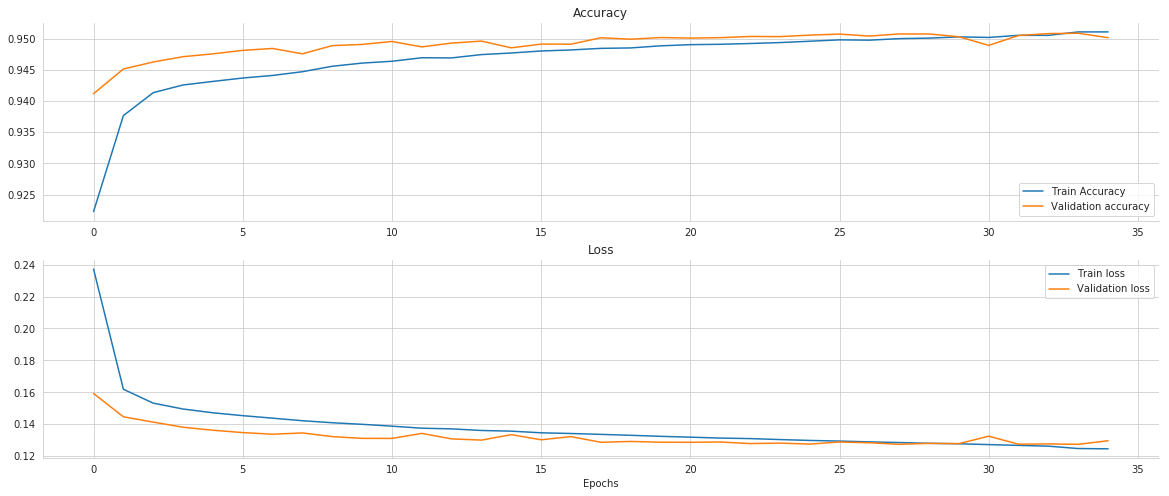

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))

ax1.plot(history.history['acc'], label='Train Accuracy')
ax1.plot(history.history['val_acc'], label='Validation accuracy')
ax1.legend(loc='best')
ax1.set_title('Accuracy')

ax2.plot(history.history['loss'], label='Train loss')
ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('Loss')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model evaluation

In [19]:
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset, subgroups, model, label_col, include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

# validate_df = pd.merge(val_ids.to_frame(), train)
validate_df['preds'] = model.predict(X_val)
validate_df = convert_dataframe_to_bool(validate_df)

bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns, 'preds', 'target')
print('Validation bias metric by group')
display(bias_metrics_df)

Validation bias metric by group


,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.9647,0.8104,homosexual_gay_or_lesbian,0.8110,2161
6,0.9669,0.7970,black,0.8167,2952
7,0.9668,0.8173,white,0.8329,5065
5,0.9648,0.8347,muslim,0.8475,4181
4,0.9549,0.8746,jewish,0.8633,1521
8,0.9706,0.8760,psychiatric_or_mental_illness,0.9058,1011
1,0.9579,0.9104,female,0.9094,10649
0,0.9611,0.9056,male,0.9127,8848
3,0.9441,0.9361,christian,0.9211,8065


In [20]:
def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

# train_df = pd.merge(train_ids.to_frame(), train)
train_df['preds'] = model.predict(X_train)
train_df = convert_dataframe_to_bool(train_df)

print('Train ROC AUC: %.4f' % get_final_metric(bias_metrics_df, metrics.roc_auc_score(train_df['target'].values, train_df['preds'].values)))
print('Validation ROC AUC: %.4f' % get_final_metric(bias_metrics_df, metrics.roc_auc_score(validate_df['target'].values, validate_df['preds'].values)))

Train ROC AUC: 0.9107
Validation ROC AUC: 0.9083


# Predictions

In [21]:
Y_test = model.predict(X_test)

In [22]:
submission = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv')
submission['prediction'] = Y_test
submission.to_csv('submission.csv', index=False)
submission.head(10)

,id,prediction
0,7000000,0.0044
1,7000001,0.0001
2,7000002,0.0050
3,7000003,0.0003
4,7000004,0.9862
5,7000005,0.0001
6,7000006,0.0003
7,7000007,0.0024
8,7000008,0.0283
9,7000009,0.0061
